# Deep KNN method

This notebook aims at evaluating the **gram method**.

The method consists in performing K-Nearest-Neighbors in the feature space of a neural
network trained on the in-distribution dataset.

Here, we focus on a toy convolutional network trained on MNIST[0-4] and a ResNet model
trained on CIFAR-10, respectively challenged on MNIST[5-9] and SVHN OOD datasets.

**Reference**
[Out-of-Distribution Detection with Deep Nearest Neighbors](http://arxiv.org/abs/2204.06507),
ICML 2022.


### Imports


In [6]:
%load_ext autoreload

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" 

from IPython.display import clear_output
import tensorflow as tf
import matplotlib.pyplot as plt

from oodeel.methods import Gram
from oodeel.eval.metrics import bench_metrics
from oodeel.eval.plots import plot_ood_scores, plot_roc_curve, plot_2D_features
from oodeel.datasets import OODDataset
from oodeel.utils.tf_training_tools import train_tf_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Note that models are saved at _~/.oodeel/saved_models_ and data is supposed to be found
at _~/.oodeel/datasets_ by default. Change the following cell for a custom path.


In [7]:
model_path = os.path.expanduser("~/") + ".oodeel/saved_models"
data_path = os.path.expanduser("~/") + ".oodeel/datasets"
os.makedirs(model_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)

## First experiment: MNIST[0-4] vs MNIST[5-9]

For this first experiment, we train a toy convolutional network on the MNIST dataset
restricted to digits 0 to 4. After fitting the train subset of this dataset to the gram
method, we will compare the scores returned for MNIST[0-4] (in-distribution) and
MNIST[5-9] (out-of-distribution) test subsets.


### Data loading

- In-distribution data: MNIST[0-4]
- Out-of-distribution data: MNIST[5-9]

> **Note:** We denote In-Distribution (ID) data with `_in` and Out-Of-Distribution (OOD)
> data with `_out` to avoid confusion with OOD detection which is the name of the task,
> and is therefore used to denote core classes such as `OODDataset` and `OODBaseDetector`.


In [3]:
# === Load ID and OOD data ===
batch_size = 128
in_labels = [0, 1, 2, 3, 4]

# 1- Load train/test MNIST dataset
ds_train = OODDataset("mnist", load_kwargs=dict(split="train"))
data_test = OODDataset("mnist", load_kwargs=dict(split="test"))

# 2- Split ID / OOD data depending on label value:
# in-distribution: MNIST[0-4] / out-of-distribution: MNIST[5-9]
ds_train, _ = ds_train.assign_ood_labels_by_class(in_labels)
oods_in, oods_out = data_test.assign_ood_labels_by_class(in_labels)


# 3- Prepare data (preprocess, shuffle, batch)
def preprocess_fn(*inputs):
    x = inputs[0] / 255
    return tuple([x] + list(inputs[1:]))


ds_train = ds_train.prepare(batch_size, preprocess_fn, shuffle=True)
ds_in = oods_in.prepare(batch_size, preprocess_fn, with_ood_labels=False)
ds_out = oods_out.prepare(batch_size, preprocess_fn, with_ood_labels=False)

clear_output()

### Model training

Now let's train a simple model on MNIST[0-4] using `train_tf_model` function.


In [4]:
# === Train / Load model ===
model_path_mnist_04 = os.path.join(model_path, "mnist_model_0-4.h5")

try:
    # if the model exists, load it
    model = tf.keras.models.load_model(model_path_mnist_04)
except OSError:
    # else, train a new model
    train_config = {
        "model": "toy_convnet",
        "input_shape": (28, 28, 1),
        "num_classes": 10,
        "batch_size": 128,
        "epochs": 5,
        "save_dir": model_path_mnist_04,
        "validation_data": ds_in,
    }

    model = train_tf_model(ds_train, **train_config)


41/41 [==============================] - 2s 37ms/step - loss: 0.0135 - accuracy: 0.9955
Test accuracy:	0.9955

=== Penultimate features viz ===


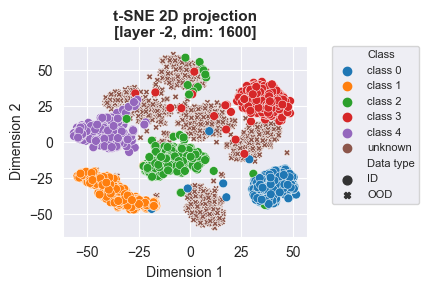

In [5]:

_, accuracy = model.evaluate(ds_in)
print(f"Test accuracy:\t{accuracy:.4f}")

# penultimate features 2d visualization
print("\n=== Penultimate features viz ===")
plt.figure(figsize=(4.5, 3))
plot_2D_features(
    model=model,
    in_dataset=ds_in,
    out_dataset=ds_out,
    output_layer_id=-2,
)
plt.tight_layout()
plt.show()

In [6]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

### gram score

We now fit a gram detector with MNIST[0-4] train dataset, and compare OOD scores
returned for MNIST[0-4] (ID) and MNIST[5-9] (OOD) test datasets.


In [7]:
# === gram scores ===
gram = Gram(output_layers_id=["conv2d", "max_pooling2d", "conv2d_1", "max_pooling2d_1"], quantile=0.01)
gram.fit(model, ds_train.take(10), val_dataset=ds_train.take(10))


In [8]:

scores_in = gram.score(ds_in)
scores_out = gram.score(ds_out)

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")


=== Metrics ===
auroc      0.825766
fpr95tpr   0.721152


In [9]:
scores_in += 1e-8
scores_out += 1e-8


=== Plots ===


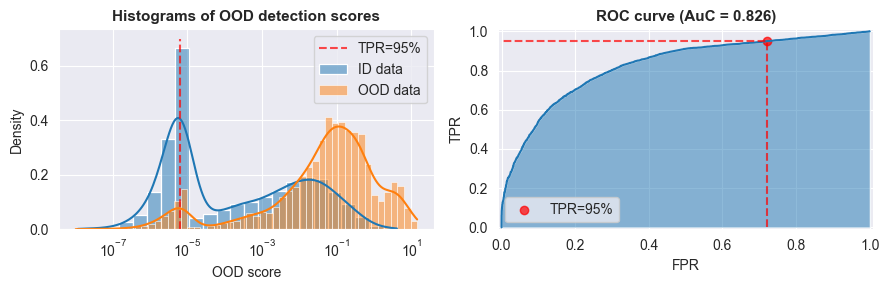

In [10]:

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=True)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

## Second experiment: CIFAR-10 vs SVHN

For this second experiment, we oppose **CIFAR-10** (in-distribution dataset) to **SVHN**
(out-of-distribution dataset).


### Data loading

- In-distribution data: CIFAR-10
- Out-of-distribution data: SVHN


In [3]:
# === Load ID and OOD data ===
batch_size = 128

# 1a- Load in-distribution dataset: CIFAR-10
ds_fit = OODDataset("cifar10", load_kwargs={"split": "train"}, input_key="image")
ds_in = OODDataset("cifar10", load_kwargs={"split": "test"}, input_key="image")

# 1b- Load out-of-distribution dataset: SVHN
ds_out = OODDataset("svhn_cropped", load_kwargs={"split": "test"})


# 2- prepare data (preprocess, shuffle, batch)
def preprocess_fn(*inputs):
    x = inputs[0] / 255
    return tuple([x] + list(inputs[1:]))


ds_fit = ds_fit.prepare(batch_size, preprocess_fn)
ds_in = ds_in.prepare(batch_size, preprocess_fn)
ds_out = ds_out.prepare(batch_size, preprocess_fn)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


### Model loading

The model is a **ResNet** pretrained on CIFAR-10 and getting an accuracy score of
92.75%.


In [8]:
# === Load model ===
# ResNet pretrained on CIFAR-10
model_path_resnet_cifar10 = tf.keras.utils.get_file(
    "cifar10_resnet256.h5",
    origin="https://share.deel.ai/s/kram9kLpx6JwRX4/download/cifar10_resnet256.h5",
    cache_dir=model_path,
    cache_subdir="",
)
model = tf.keras.models.load_model(model_path_resnet_cifar10)


79/79 [==============================] - 28s 307ms/step - loss: 0.1268 - accuracy: 0.9276
Test accuracy:	0.9276

=== Penultimate features viz ===


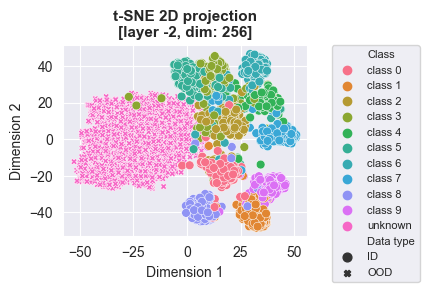

In [ ]:

# Evaluate model
model.compile(metrics=["accuracy"])
_, accuracy = model.evaluate(ds_in)
print(f"Test accuracy:\t{accuracy:.4f}")

# penultimate features 2d visualization
print("\n=== Penultimate features viz ===")
plt.figure(figsize=(4.5, 3))
plot_2D_features(
    model=model,
    in_dataset=ds_in,
    out_dataset=ds_out,
    output_layer_id=-2,
)
plt.tight_layout()
plt.show()

### gram score

We now fit a gram detector with CIFAR-10 train dataset, and compare OOD scores returned
for CIFAR-10 (ID) and SVHN (OOD) test datasets.


In [11]:
# === gram scores ===
%autoreload 2 


gram = Gram(output_layers_id=['add_5', 'activation_18', 'add_11', 'activation_36', 'add_17', 'activation_54'], orders = [i for i in range(1, 10)])
gram.fit(model, ds_fit.take(50), val_dataset=ds_fit.take(10))
scores_in = gram.score(ds_in)
scores_out = gram.score(ds_out)

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")


=== Metrics ===
auroc      0.830956
fpr95tpr   0.710900


In [13]:
scores_in = gram.score(ds_in)


=== Plots ===


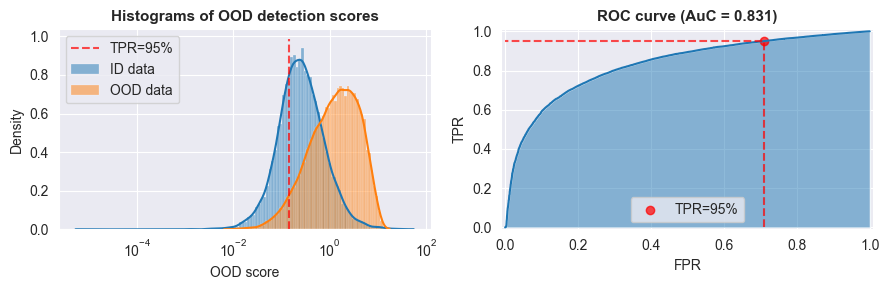

In [12]:

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=True)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()